In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix



In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
dataset_path = '/content/drive/MyDrive/DL_PROJECT_DATASET/Final_Dataset'
print("Classes:", os.listdir(dataset_path))

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    print(cls, ":", len(os.listdir(cls_path)))


Classes: ['tree', 'building', 'car', 'lab', 'person']
tree : 573
building : 368
car : 556
lab : 447
person : 419


In [10]:
img_size = (224,224)
batch_size = 32
seed = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.30,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.30,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()
val_batches = temp_batches // 2

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

class_names = train_ds.class_names
print(class_names)


Found 2363 files belonging to 5 classes.
Using 1655 files for training.
Found 2363 files belonging to 5 classes.
Using 708 files for validation.
['building', 'car', 'lab', 'person', 'tree']


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x,y:(x, tf.one_hot(y,5)))
val_ds   = val_ds.map(lambda x,y:(x, tf.one_hot(y,5)))
test_ds  = test_ds.map(lambda x,y:(x, tf.one_hot(y,5)))

def preprocess(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess).prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess).prefetch(AUTOTUNE)

In [12]:
def coordinate_attention(x, r=32):
    c = x.shape[-1]

    h = tf.reduce_mean(x, axis=2, keepdims=True)
    w = tf.reduce_mean(x, axis=1, keepdims=True)
    w = tf.transpose(w, [0,2,1,3])

    y = layers.Concatenate(axis=1)([h,w])
    y = layers.Conv2D(c//r, 1, activation='relu')(y)

    h,w = tf.split(y, 2, axis=1)
    w = tf.transpose(w, [0,2,1,3])

    h = layers.Conv2D(c, 1, activation='sigmoid')(h)
    w = layers.Conv2D(c, 1, activation='sigmoid')(w)

    return x * h * w


In [14]:
from tensorflow.keras import layers

class CoordinateAttention(layers.Layer):
    def __init__(self, reduction=32, **kwargs):
        super().__init__(**kwargs)
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        reduced_channels = max(8, self.channels // self.reduction)

        self.conv1 = layers.Conv2D(
            reduced_channels, kernel_size=1, activation='relu'
        )
        self.conv_h = layers.Conv2D(
            self.channels, kernel_size=1, activation='sigmoid'
        )
        self.conv_w = layers.Conv2D(
            self.channels, kernel_size=1, activation='sigmoid'
        )

    def call(self, x):
        # Average pooling along width
        h = layers.Lambda(lambda x: tf.reduce_mean(x, axis=2, keepdims=True))(x)
        # Average pooling along height
        w = layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(x)
        w = layers.Permute((2,1,3))(w)

        y = layers.Concatenate(axis=1)([h, w])
        y = self.conv1(y)

        h_att, w_att = tf.split(y, num_or_size_splits=2, axis=1)
        w_att = layers.Permute((2,1,3))(w_att)

        h_att = self.conv_h(h_att)
        w_att = self.conv_w(w_att)

        return x * h_att * w_att


In [15]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = False

x = base_model.output
x = CoordinateAttention()(x)   # ✅ Coordinate Attention
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,212,176 (16.07 MB)

 Trainable params: 162,605 (635.18 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=25)


Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 518s 10s/step - accuracy: 0.6536 - loss: 1.1523 - val_accuracy: 0.9233 - val_loss: 0.2568
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 352s 6s/step - accuracy: 0.9460 - loss: 0.2105 - val_accuracy: 0.9517 - val_loss: 0.1700
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 337s 6s/step - accuracy: 0.9616 - loss: 0.1374 - val_accuracy: 0.9489 - val_loss: 0.1577
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.9744 - loss: 0.1071 - val_accuracy: 0.9545 - val_loss: 0.1409
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 305s 6s/step - accuracy: 0.9709 - loss: 0.1034 - val_accuracy: 0.9574 - val_loss: 0.1398
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 334s 6s/step - accuracy: 0.9784 - loss: 0.0878 - val_accuracy: 0.9602 - val_loss: 0.1339
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1706s 33s/step - accuracy: 0.9801 - loss: 0.0659 - val_accuracy: 0.9801 - val_loss: 0.0905
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.9829 - loss: 0.0582 - val_accuracy: 0.9631 

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=2
))


              precision    recall  f1-score   support

    building       0.93      0.93      0.93        41
         car       0.99      0.97      0.98        88
         lab       1.00      1.00      1.00        73
      person       0.97      0.97      0.97        70
        tree       0.94      0.96      0.95        84

    accuracy                           0.97       356
   macro avg       0.97      0.97      0.97       356
weighted avg       0.97      0.97      0.97       356



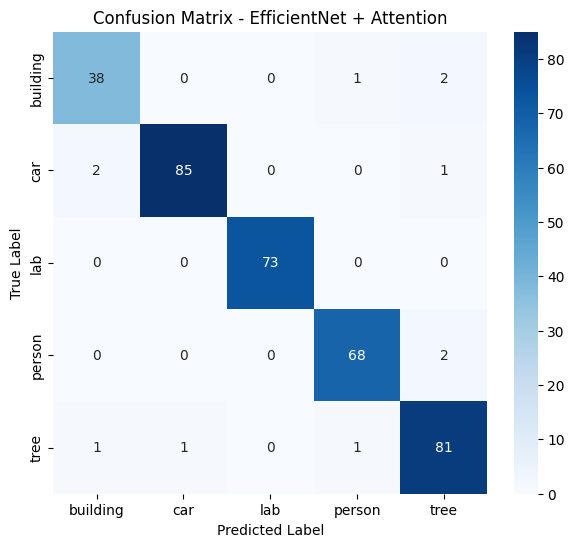

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - EfficientNet + Attention")
plt.show()


In [19]:
y_true, y_pred = [], []

for x,y in test_ds:
    preds = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Test Accuracy:", np.mean(np.array(y_true)==np.array(y_pred)))
print(classification_report(y_true, y_pred, target_names=class_names))


Test Accuracy: 0.9803370786516854
              precision    recall  f1-score   support

    building       0.96      0.98      0.97        46
         car       0.99      0.98      0.98        81
         lab       0.99      1.00      0.99        78
      person       0.99      0.99      0.99        67
        tree       0.98      0.96      0.97        84

    accuracy                           0.98       356
   macro avg       0.98      0.98      0.98       356
weighted avg       0.98      0.98      0.98       356



In [23]:
model.save('/content/drive/MyDrive/efficientnet_b0_coord.keras')
print("✅ Coordinate Attention model saved successfully!")


✅ Coordinate Attention model saved successfully!


In [1]:
from google.colab import files
files.download('efficientnet_b0_coord.ipynb')


FileNotFoundError: Cannot find file: efficientnet_b0_coord.ipynb